# Part A: Object Recognition

The project uses a sample of the CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
# import relevant libraries
from matplotlib import pyplot as plt

import numpy as np
import pickle
import tensorflow as tf

In [ ]:
# make sure Google Colaboratory is using GPU instance
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# set-up
seed = 0  # for replication of results
tf.random.set_seed(seed)

The dataset contains RGB color images of size 32x32 and their corresponding labels from 0 to 9. You will be using the **batch_1** of the dataset, which contains 10,000 training samples. Testing is done on 2,000 test samples. The training data and testing data are provided in files **'data_batch_1'** and **'test_batch_trim'**, respectively. Sample code is given in file **start_2a.py**.

In [ ]:
# try seeing what the data is like first

# data uploaded to 'content/' folder in Google Colaboratory
train_data_path = '/content/CZ4042_assignment2/data_batch_1'
test_data_path = '/content/CZ4042_assignment2/test_batch_trim'


def unpickle(data_file_path):
    with open(data_file_path, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


train_data = unpickle(train_data_path)
test_data = unpickle(test_data_path)

print(f'train data type: {type(train_data)}')
print(f'test data type: {type(test_data)}')

train data type: <class 'dict'>
test data type: <class 'dict'>


In [ ]:
# confirm the layout of the data
print('train data key-value pairs:')
for key, value in train_data.items():
    print(key, '- value type:', type(value))

print()

print('test data key-value pairs:')
for key, value in test_data.items():
    print(key, '- value type:', type(value))

train data key-value pairs:
b'batch_label' - value type: <class 'bytes'>
b'labels' - value type: <class 'list'>
b'data' - value type: <class 'numpy.ndarray'>
b'filenames' - value type: <class 'list'>

test data key-value pairs:
b'batch_label' - value type: <class 'bytes'>
b'labels' - value type: <class 'numpy.ndarray'>
b'data' - value type: <class 'numpy.ndarray'>
b'filenames' - value type: <class 'list'>


In [ ]:
print(train_data[b'batch_label'])
print(train_data[b'data'].shape)

# view first train datum information
print(train_data[b'labels'][0])
print(train_data[b'data'][0])
print(train_data[b'filenames'][0])

b'training batch 1 of 5'
(10000, 3072)
6
[ 59  43  50 ... 140  84  72]
b'leptodactylus_pentadactylus_s_000004.png'


In [ ]:
print(test_data[b'batch_label'])
print(test_data[b'labels'].shape)
print(test_data[b'data'].shape)

# view first test datum information
print(test_data[b'labels'][0])
print(test_data[b'data'][0])
print(test_data[b'filenames'][0])

b'test batch trimmed'
(2000,)
(2000, 3072)
5
[217 213 218 ... 214 214 215]
b'pekingese_s_001391.png'


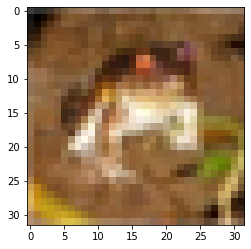

(32, 32, 3)


In [ ]:
# reference: # https://stackoverflow.com/a/45872158/9171260
def reshape_image(image: np.ndarray) -> np.ndarray:
    '''
    Reshapes image from (3072,) to (32, 32, 3)
    '''
    image_r = image[0:1024].reshape(32, 32)
    image_g = image[1024:2048].reshape(32, 32)
    image_b = image[2048:].reshape(32, 32)

    return np.dstack((image_r, image_g, image_b))


# visualise the first training image
first_image = train_data[b'data'][0]
first_image = reshape_image(first_image)

plt.imshow(first_image, interpolation='nearest')
plt.show()
print(first_image.shape)

In [ ]:
# prepare data for tasks below
# reference: given sample code

# although training labels are in a list and test labels are in a np.ndarray,
# they can be treated the same way (same shape essentially)


# reference: https://stackoverflow.com/a/45604712/9171260
def reshape_image_array(image_array: np.ndarray) -> np.ndarray:
    '''
    Reshapes the entire image array, 
    from (num_images, 3072)
    to (num_images, 32, 32, 3)
    '''
    return np.apply_along_axis(reshape_image, 1, image_array)


train_features = np.array(train_data[b'data'], dtype=np.float32)
train_features = reshape_image_array(train_features)
train_features /= 255  # rescale to 0 - 1
print(f'train features shape: {train_features.shape}')

train_labels = np.array(train_data[b'labels'], dtype=np.int32)
print(f'train labels shape: {train_labels.shape}')

test_features = np.array(test_data[b'data'], dtype=np.float32)
test_features = reshape_image_array(test_features)
test_features /= 255  # rescale to 0 - 1
print(f'test features shape: {test_features.shape}')

test_labels = np.array(test_data[b'labels'], dtype=np.int32)
print(f'test labels shape: {test_labels.shape}')

train features shape: (10000, 32, 32, 3)
train labels shape: (10000,)
test features shape: (2000, 32, 32, 3)
test labels shape: (2000,)


Design a convolutional neural network consisting of:
- An Input layer of 32x32x3 dimensions
- A convolution layer $C_1$ with 50 channels, window size 9x9, VALID padding, and ReLU activation
- A max pooling layer $S_1$ with a pooling window of size 2x2, stride = 2, and VALID padding
- A convolution layer $C_2$ with 60 channels, window size 5x5, VALID padding, and ReLU activation
- A max pooling layer $S_2$ with a pooling window of size 2x2, stride = 2, and VALID padding
- A fully-connected layer $F_3$ of size 300 with no activation
- A fully-connected layer $F_4$ of size 10 with Softmax activation

In [ ]:
def get_cnn(
    num_c1_filters: int = 50,
    num_c2_filters: int = 60,
    use_dropout: bool = False,
) -> tf.keras.Sequential:
    '''
    Generates a CNN with 2 convolutional and 2 fully-connected layers.

    :params:
    num_c1_filters (int): number of filters in convolutional layer c1 (default: 50)  
    num_c2_filters (int): number of filters in convolutional layer c2 (default: 60)  
    use_dropout (bool): whether to use dropout with probability 0.5 (default: False)  

    :return:
    model (tf.keras.Sequential)
    '''
    model = tf.keras.Sequential()

    input_layer = tf.keras.layers.Input(shape=(32, 32, 3))
    model.add(input_layer)

    c1 = tf.keras.layers.Conv2D(
        filters=num_c1_filters,
        kernel_size=(9, 9),
        padding='valid',
        activation='relu',
    )
    model.add(c1)

    s1 = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        strides=2,
        padding='valid',
    )
    model.add(s1)

    c2 = tf.keras.layers.Conv2D(
        filters=num_c2_filters,
        kernel_size=(5, 5),
        padding='valid',
        activation='relu',
    )
    model.add(c2)

    s2 = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        strides=2,
        padding='valid',
    )
    model.add(s2)

    flatten = tf.keras.layers.Flatten()
    model.add(flatten)

    f3 = tf.keras.layers.Dense(
        units=300,
    )
    model.add(f3)

    if use_dropout:
        dropout = tf.keras.layers.Dropout(
            rate=0.5,
            seed=seed,
        )
        model.add(dropout)

    f4 = tf.keras.layers.Dense(
        units=10,
        # no need for softmax due to sparse categorical crossentropy loss
        # based on sample code
    )
    model.add(f4)

    if use_dropout:
        dropout = tf.keras.layers.Dropout(
            rate=0.5,
            seed=seed,
        )
        model.add(dropout)

    return model

# 1.

Train the network using mini-batch gradient descent learning for 1000 epochs. Set the batch size to 128, and learning rate α = 0.001.

1. Plot the (1) training cost, (2) test cost, (3) training accuracy, and (4) test accuracy against learning epochs. One plot for the costs and one plot for the accuracies.
2. For the first two test images, plot the feature maps at both convolution layers
($C_1$ and $C_2$) and pooling layers ($S_1$ and $S_2$) along with the test images. (In total one
image and four feature maps)

Note: A feature map with N channels can be viewed as N grayscale images. Do make sure that the pixel values are in the correct range when you plot them.


In [ ]:
# define training params
num_epochs = 1000
batch_size = 128
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

In [ ]:
# get the model
model = get_cnn()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 50)        12200     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 60)          75060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 60)          0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               288300    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [ ]:
%%time
# train the network using mini-batch gradient descent learning
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
)

Epoch 1/1000
79/79 [==============================] - 1s 9ms/step - loss: 2.3117 - accuracy: 0.1103 - val_loss: 2.3032 - val_accuracy: 0.1255
Epoch 2/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.2988 - accuracy: 0.1303 - val_loss: 2.2944 - val_accuracy: 0.1375
Epoch 3/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.2907 - accuracy: 0.1452 - val_loss: 2.2870 - val_accuracy: 0.1515
Epoch 4/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.2832 - accuracy: 0.1618 - val_loss: 2.2797 - val_accuracy: 0.1620
Epoch 5/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.2760 - accuracy: 0.1738 - val_loss: 2.2723 - val_accuracy: 0.1820
Epoch 6/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.2684 - accuracy: 0.1882 - val_loss: 2.2642 - val_accuracy: 0.1930
Epoch 7/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.2600 - accuracy: 0.2009 - val_loss: 2.2555 - val_accuracy: 0.1930
Epoch 

In [ ]:
# define function to plot loss and accuracy curves for usage later
def plot_loss_accuracy_curves(num_epochs: int, history: dict):
    '''
    Plots loss curve and accuracy curve side-by-side.
    
    :params:
    - total_num_epochs (int): total number of epochs for model to get minimal test error
    - history (dict): history of loss and accuracy values at each epoch
        - keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy'
    '''
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title('loss')
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
    loss_axis.legend()

    accuracy_axis.set_title('accuracy')
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
    accuracy_axis.legend()

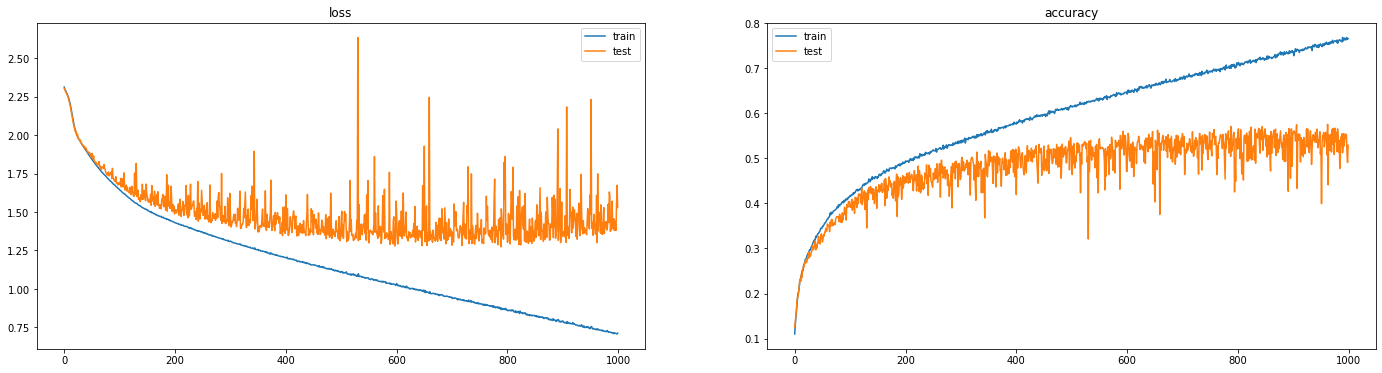

In [ ]:
# Plot the (1) training cost, (2) test cost, (3) training accuracy, and 
# (4) test accuracy against learning epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

In [ ]:
# 2. For the first two test images, 
# plot the feature maps at both convolution layers (C1 and C2) and 
# pooling layers (S1 and S2) along with the test images.

# reference: https://stackoverflow.com/a/41712013/9171260
inputs = [model.input]
outputs = [model.layers[index].output for index in range(4)]

get_feature_maps = tf.keras.backend.function(inputs, outputs)

layers = ['C1', 'S1', 'C2', 'S2']


# plot in order in network: C1, S1, C2, S2
def plot_feature_maps(image_features):
    image_features = image_features.reshape((1, 32, 32, 3))

    feature_maps = get_feature_maps(image_features)

    for index, feature_map in enumerate(feature_maps):
        print(f'feature map for {layers[index]}')

        feature_map = feature_map.reshape(tuple(feature_map.shape[1:]))
        feature_map = np.moveaxis(feature_map, -1, 0)

        feature_map *= 255

        num_channels = feature_map.shape[0]
        num_rows = num_channels // 10
        num_columns = 10

        figure, axes = plt.subplots(
            nrows=num_rows,
            ncols=num_columns,
            figsize=(num_columns * 3, num_rows *3),
        )

        [axis.set_axis_off() for axis in axes.ravel()]
        
        for index, channel_features in enumerate(feature_map):
            figure.add_subplot(num_rows, num_columns, index + 1)
            plt.imshow(channel_features)

        figure.tight_layout()
        plt.show()

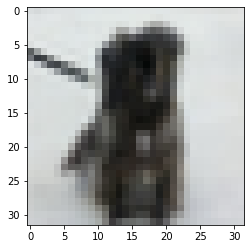

feature map for C1


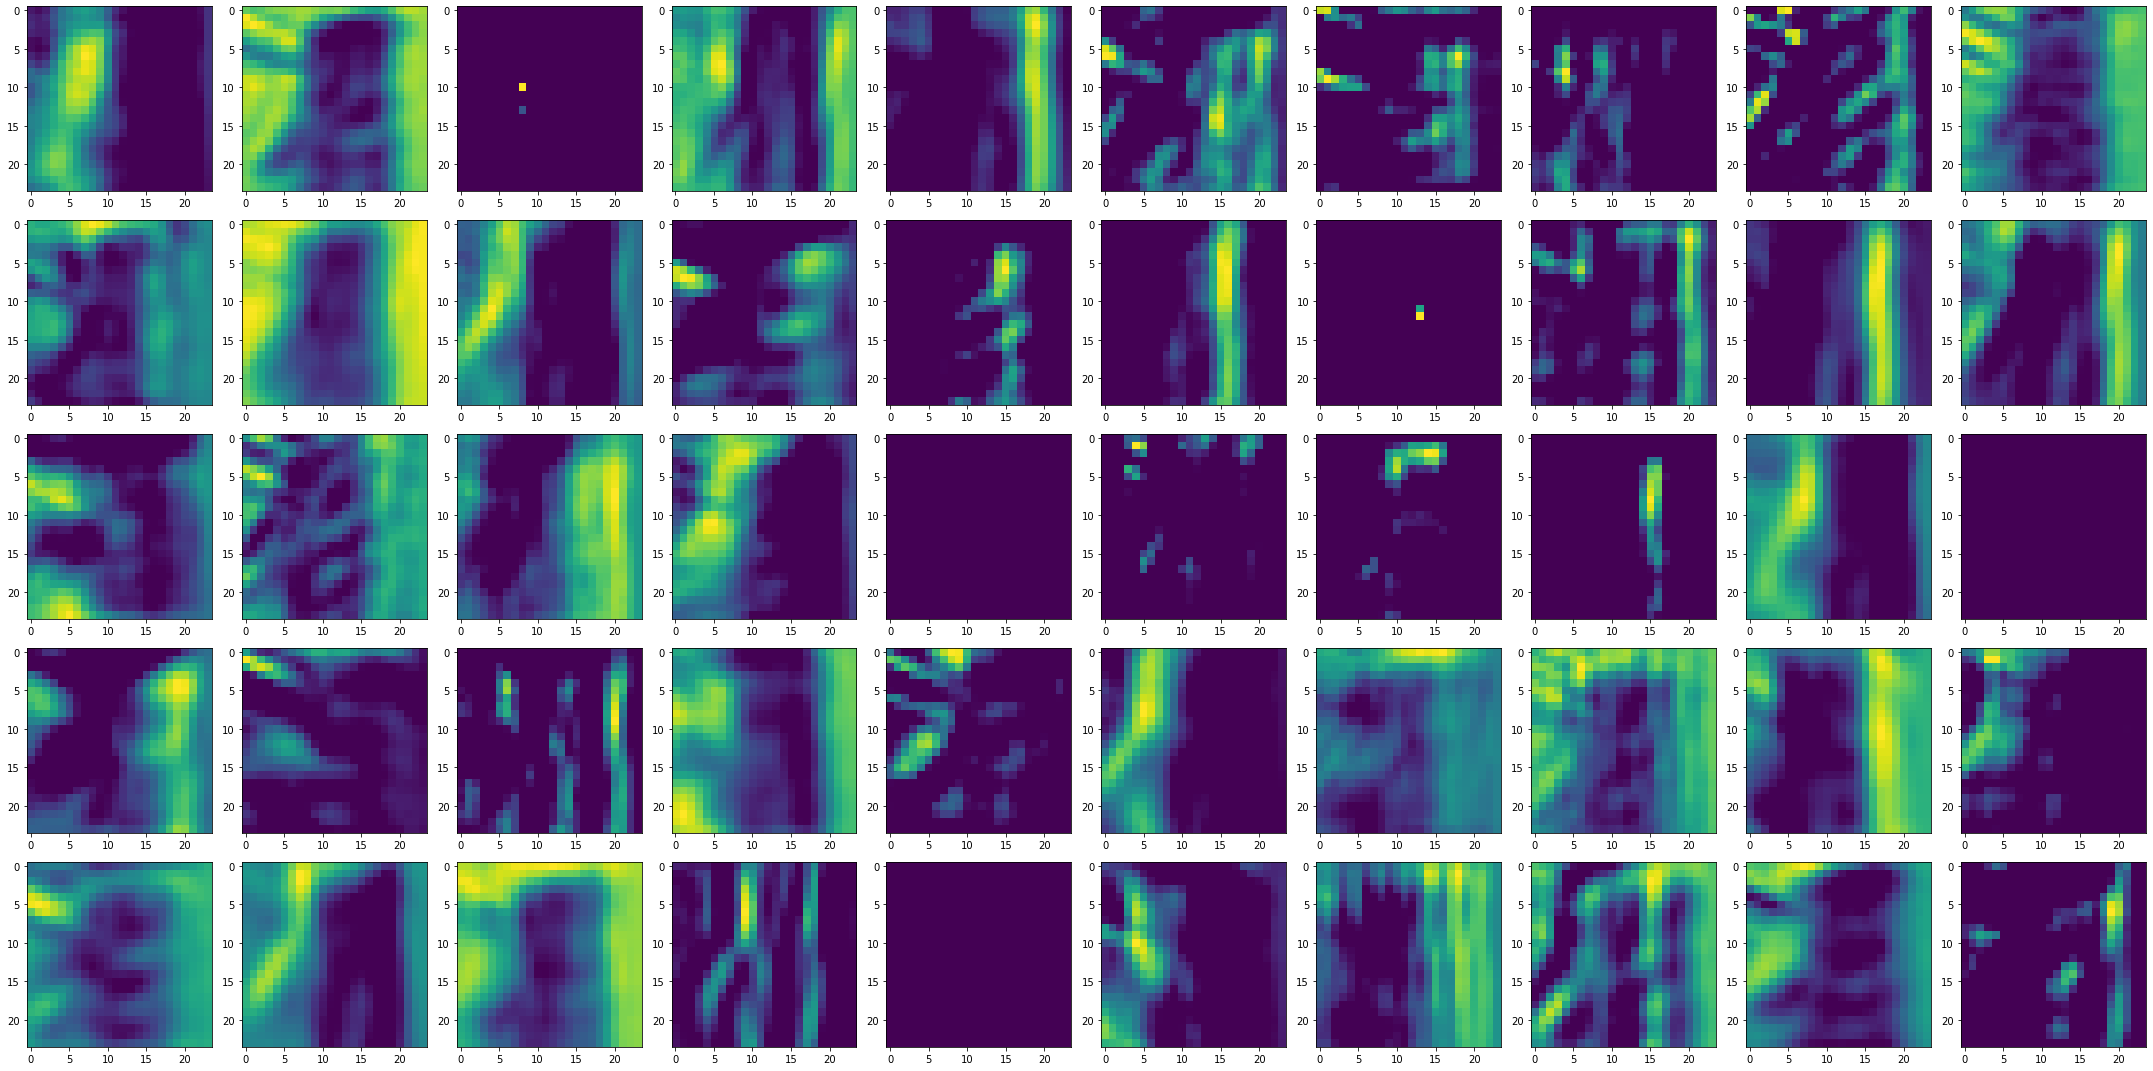

feature map for S1


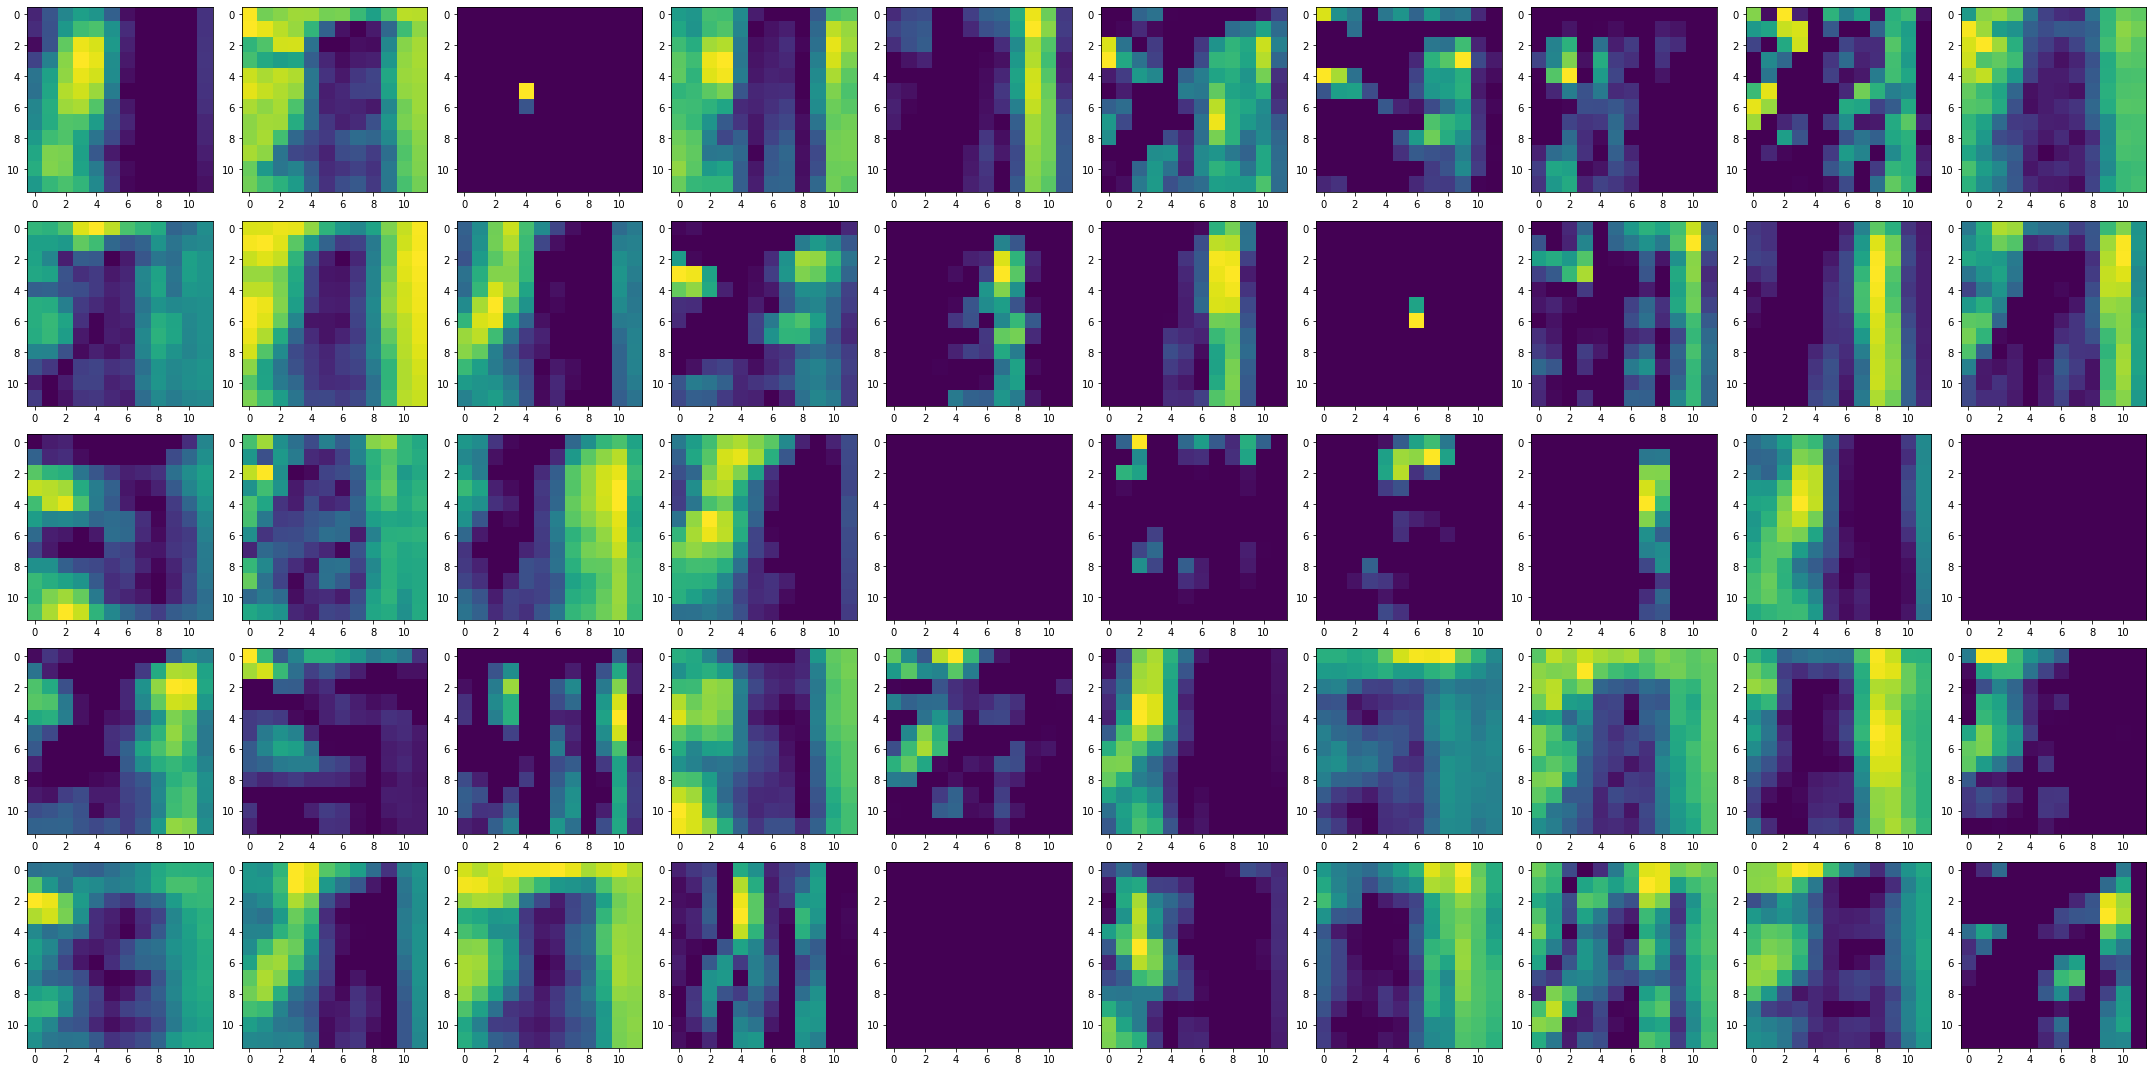

feature map for C2


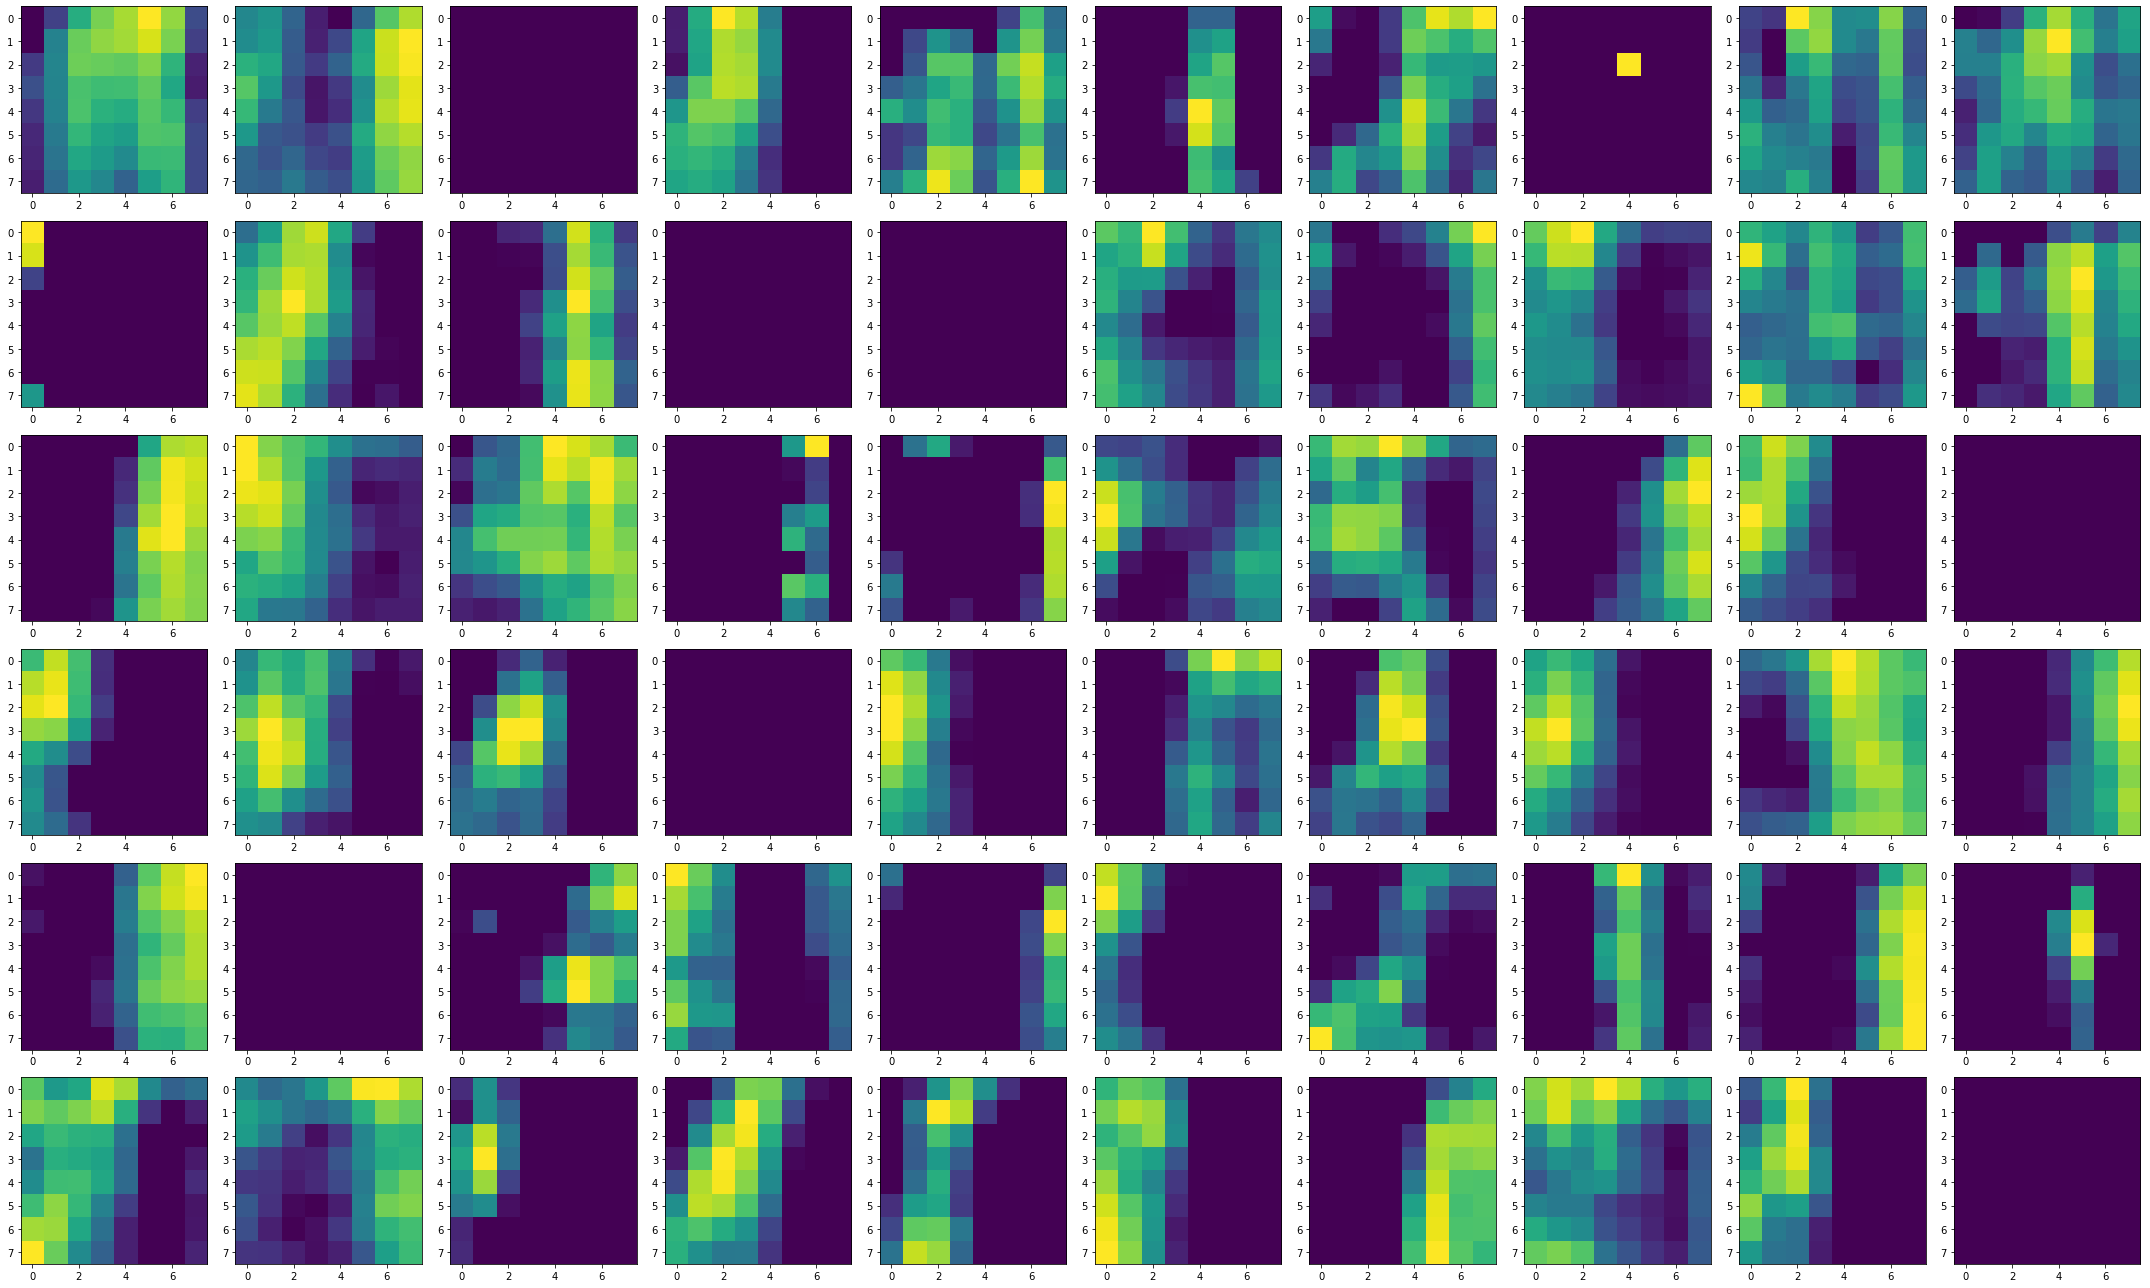

feature map for S2


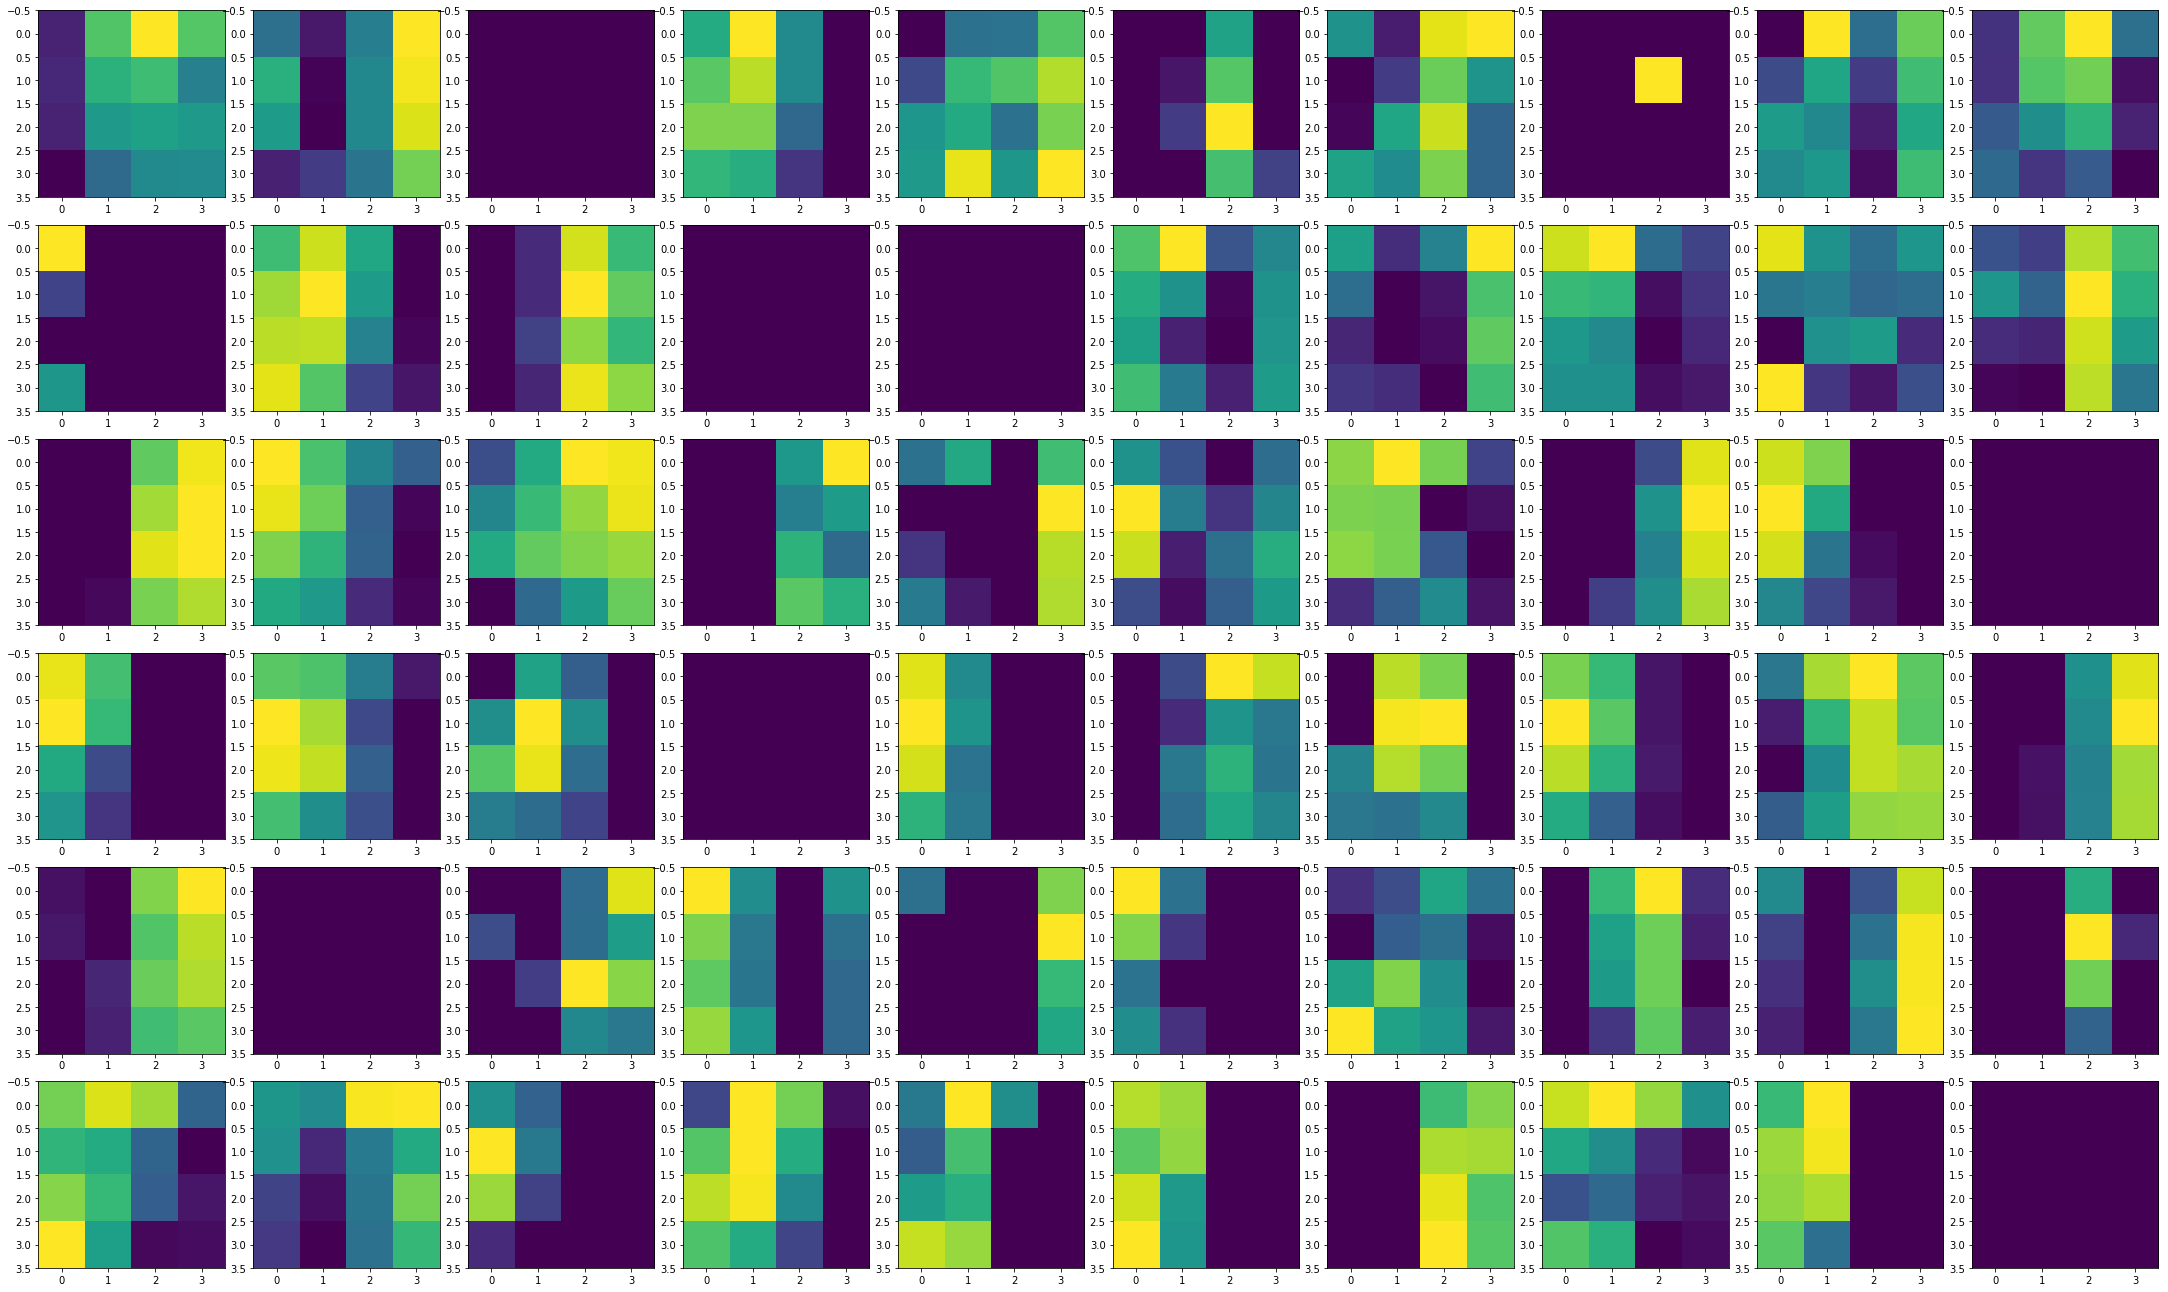

In [ ]:
# first test image and feature maps
plt.imshow(test_features[0])
plt.show()
plot_feature_maps(test_features[0])

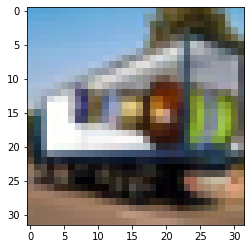

feature map for C1


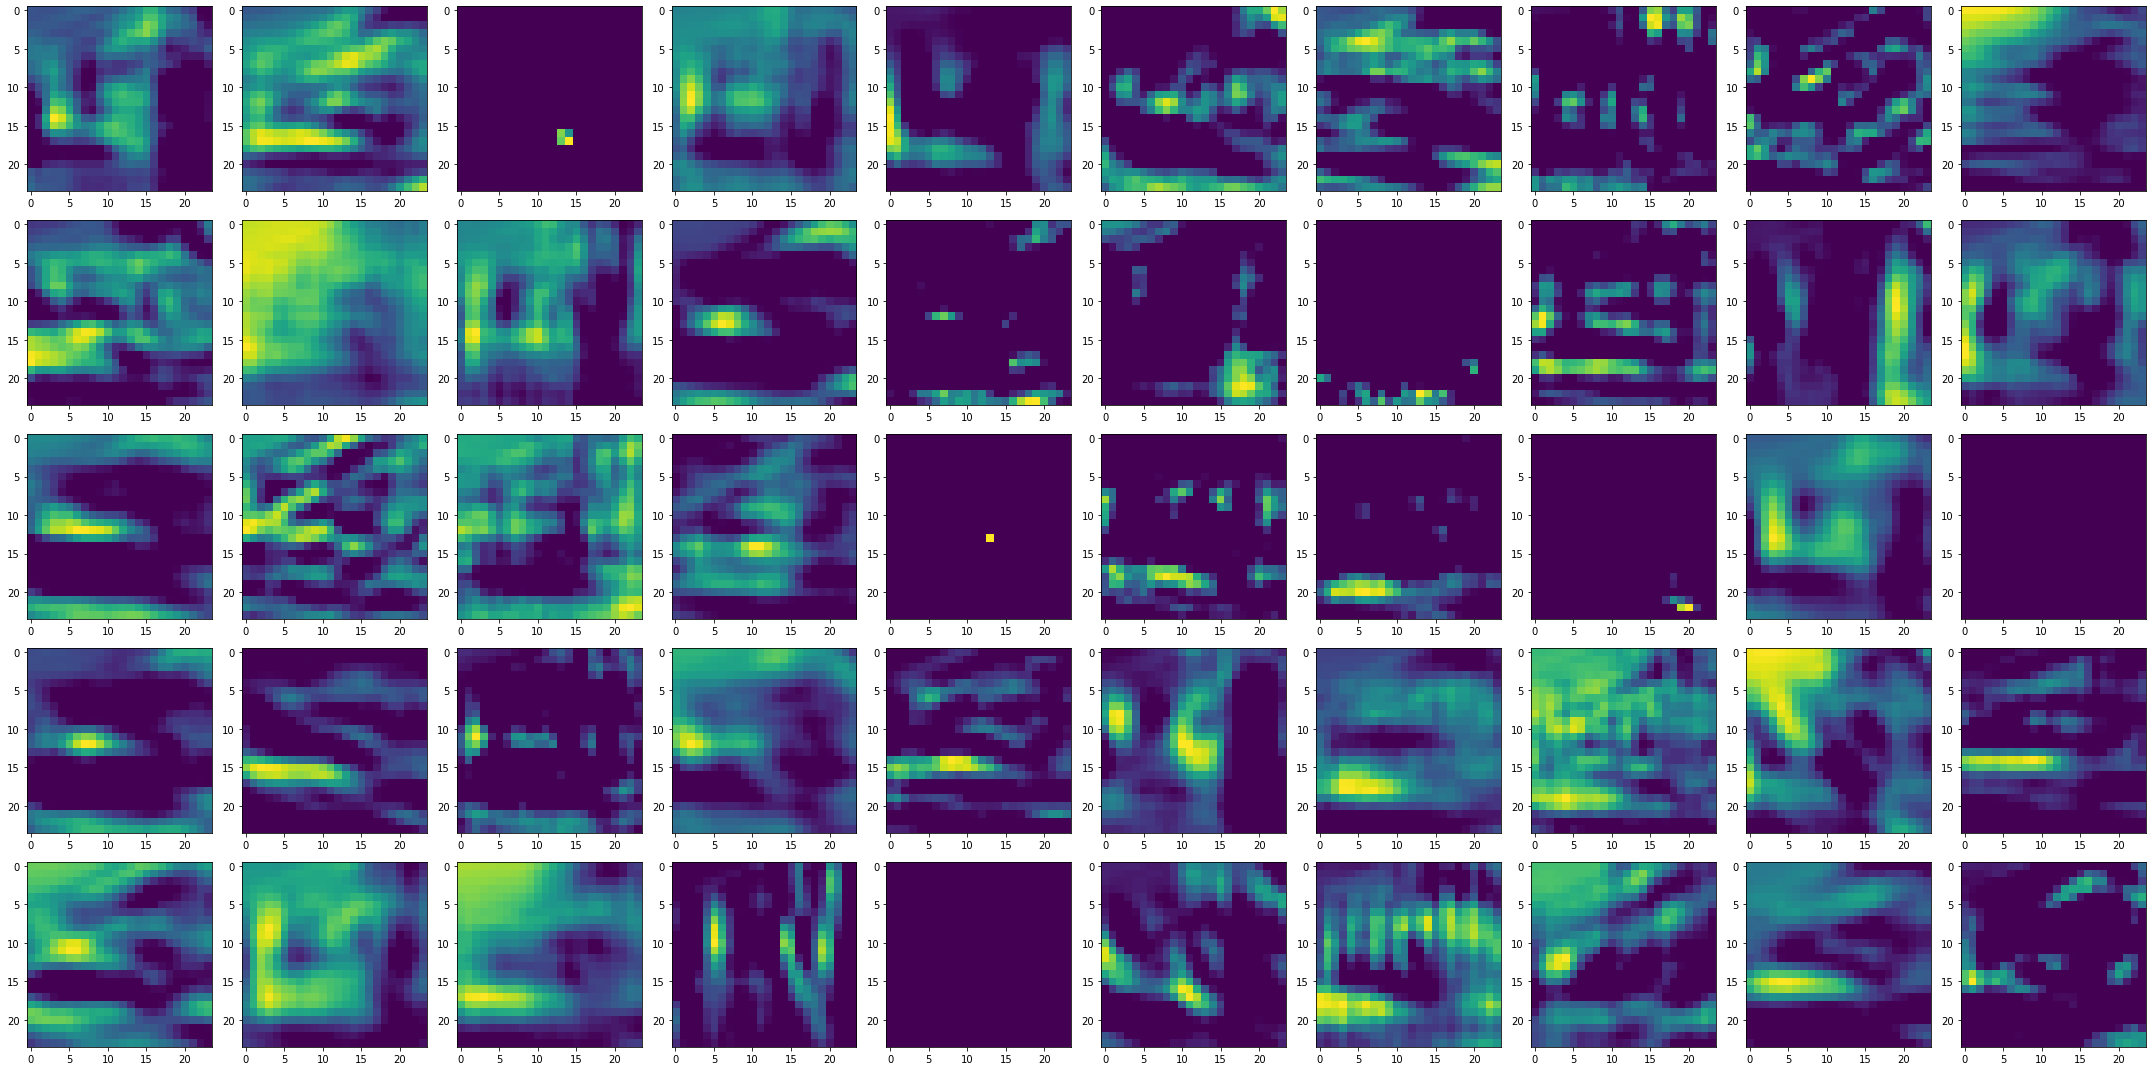

feature map for S1


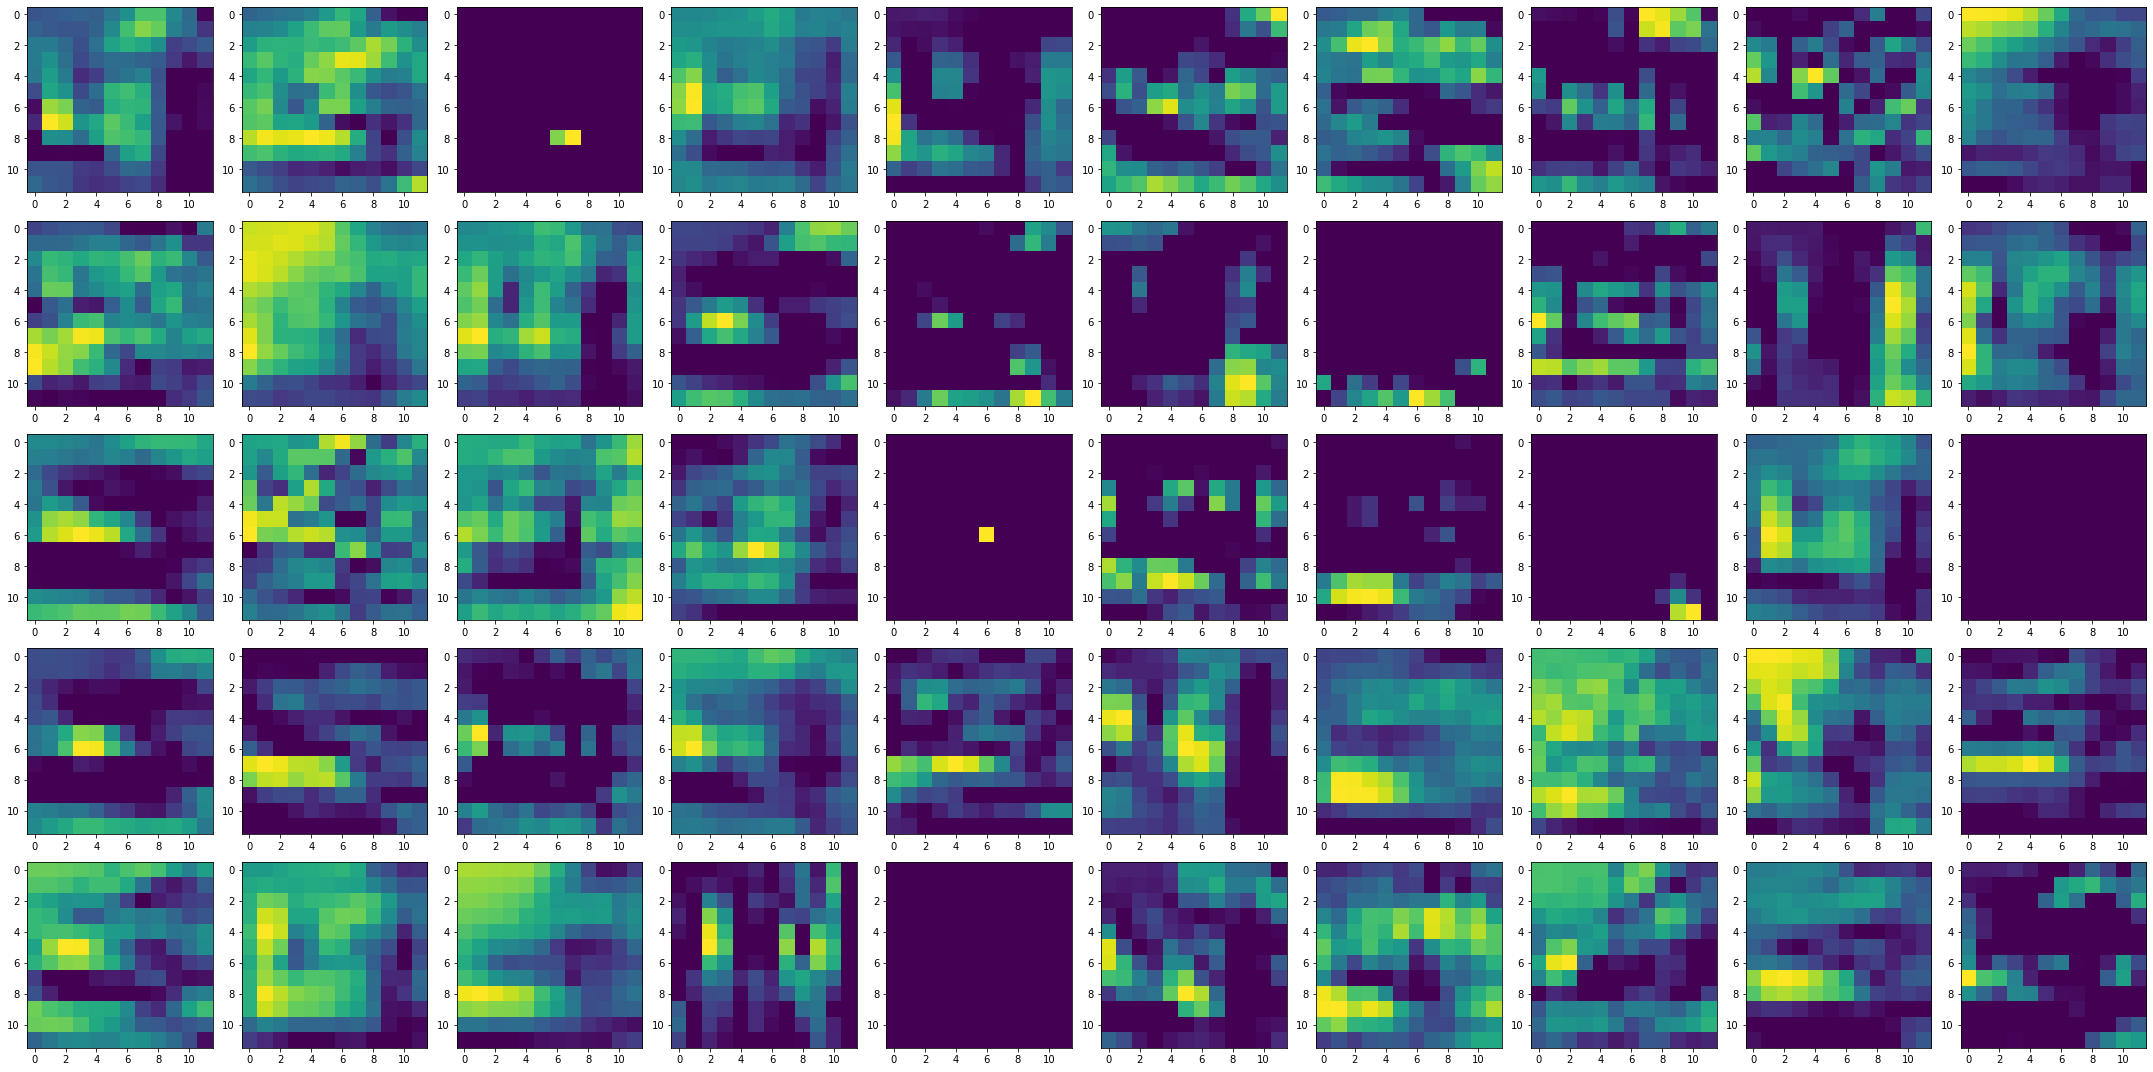

feature map for C2


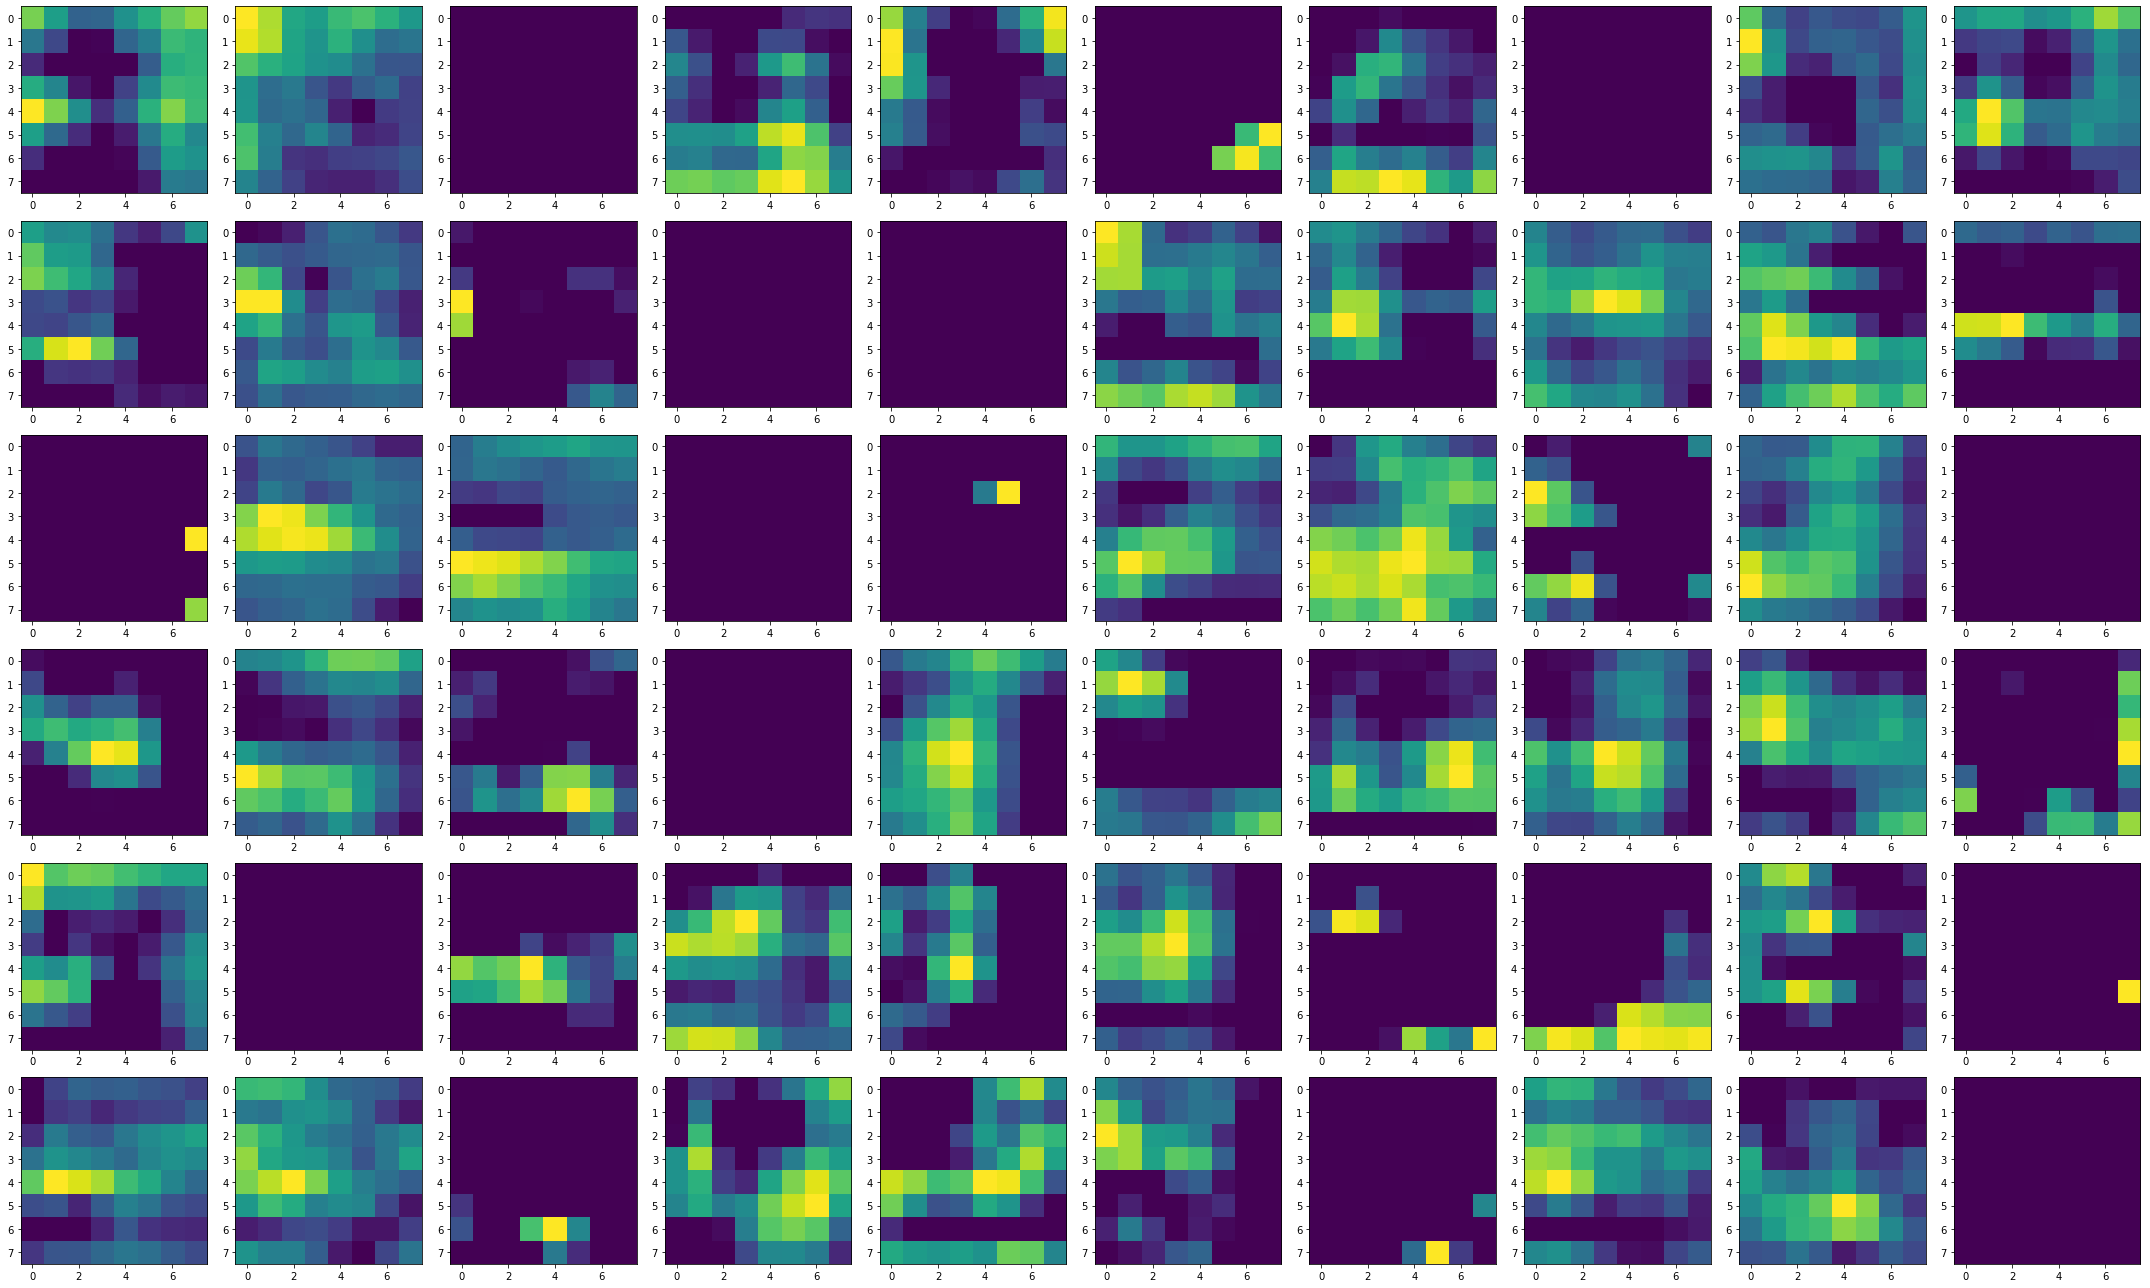

feature map for S2


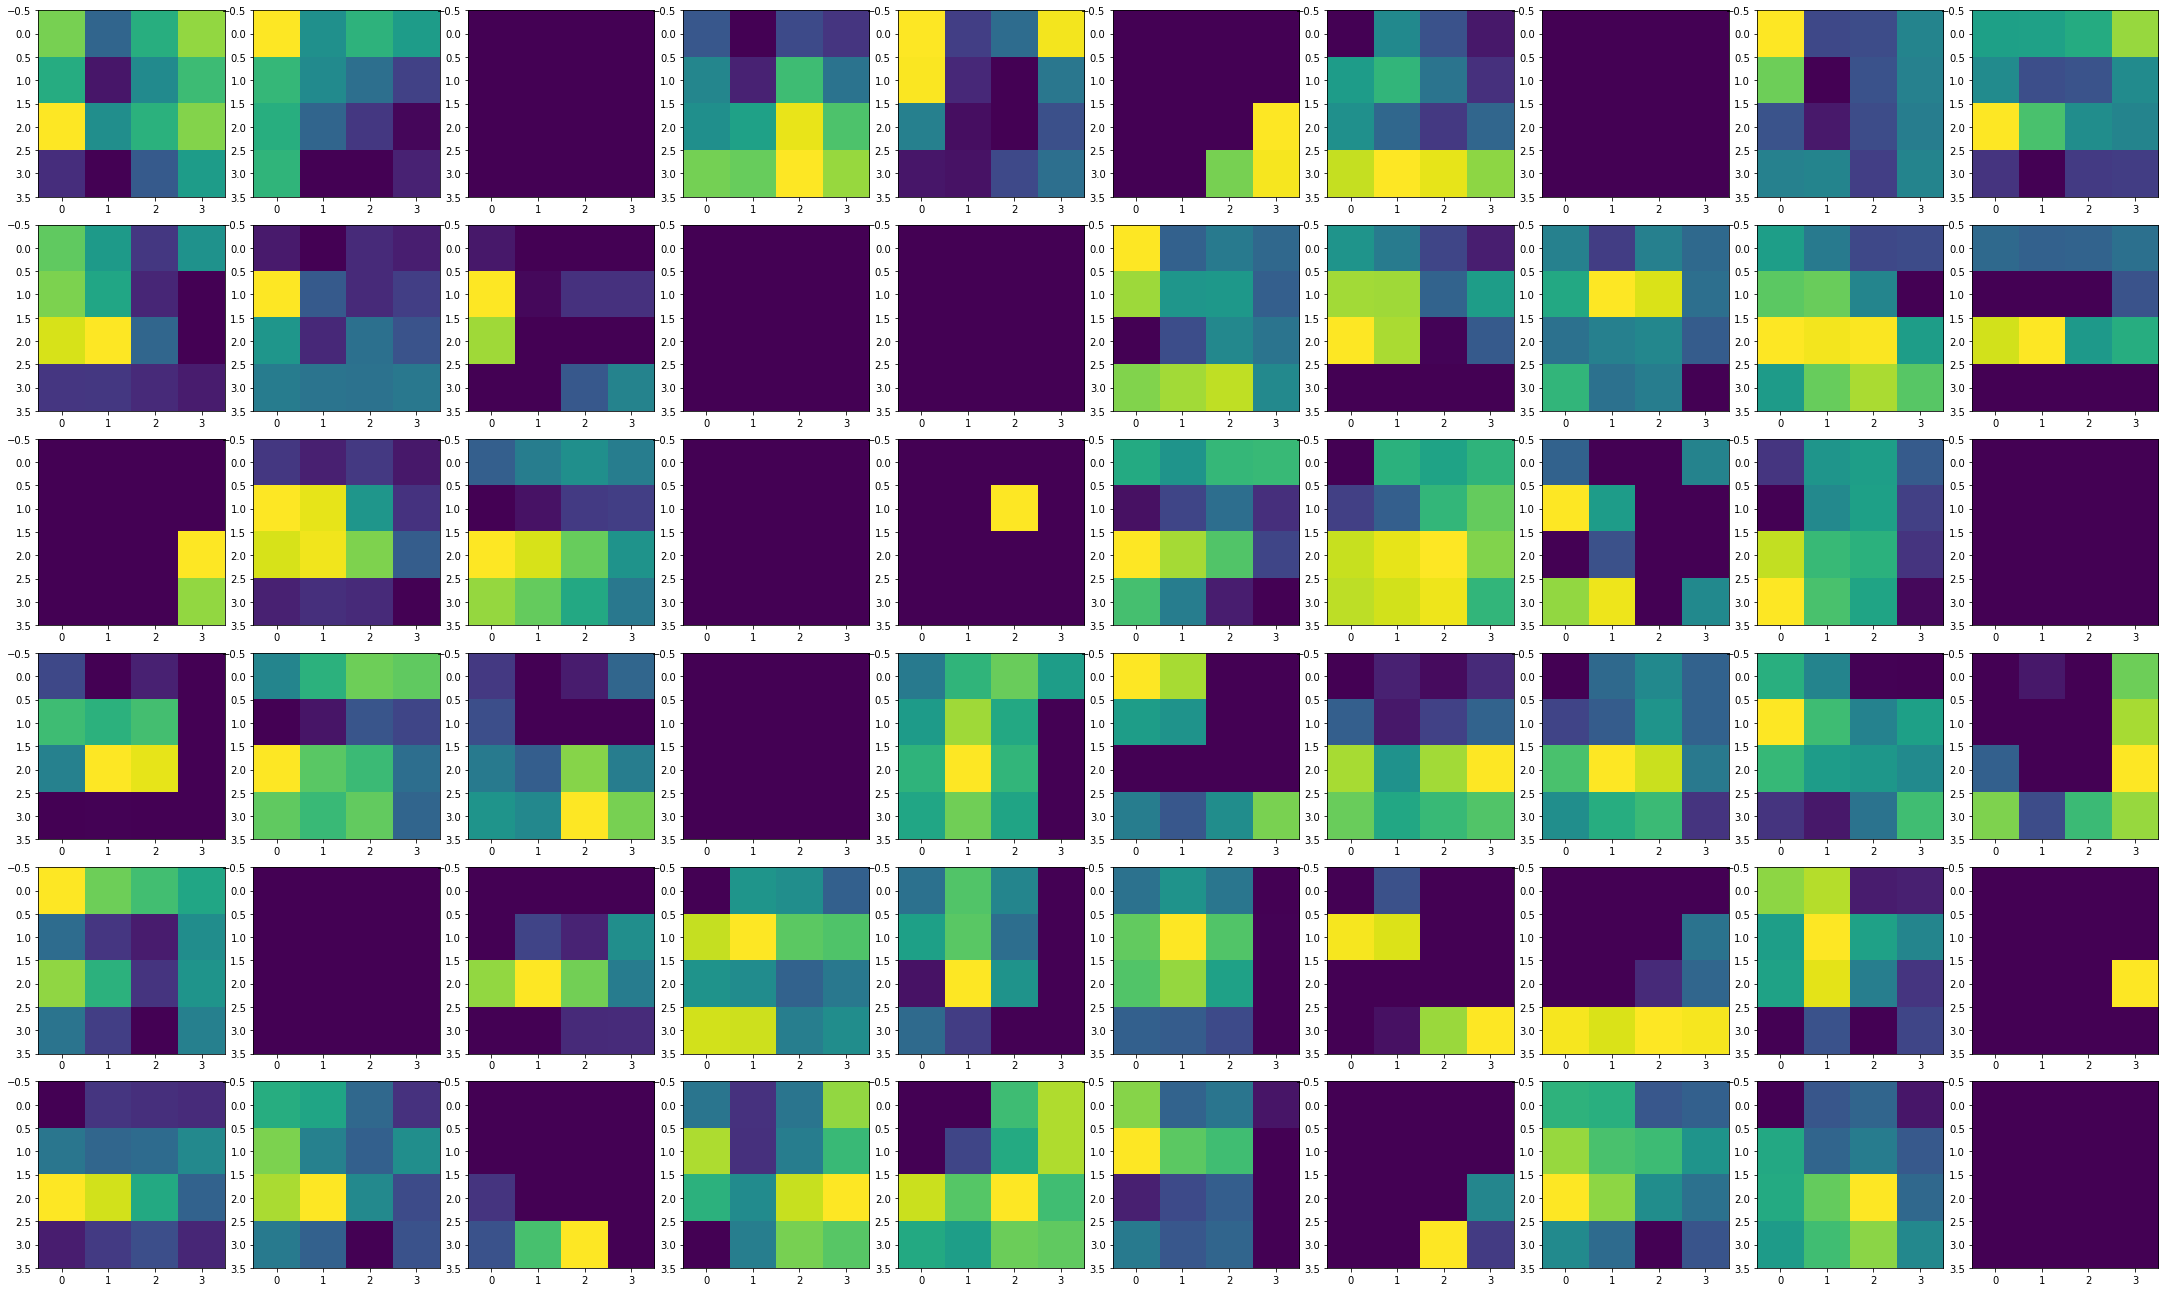

In [ ]:
# second test image and feature maps
plt.imshow(test_features[1])
plt.show()
plot_feature_maps(test_features[1])

# 2.

Use a grid search ( $C_1 ∈ \{10, 30, 50, 70, 90\}$, $C_2 ∈ \{20, 40, 60, 80, 100\}$, in total 25 combinations) to find the optimal combination of the numbers of channels at the convolution layers. Use the test accuracy to determine the optimal combination. Report all 25 accuracies.

In [ ]:
def grid_search_conv_channels(num_c1_channels_list, num_c2_channels_list):
    '''
    Perform grid search to find optimum combination of C1 and C2 channels.
    '''
    histories = {}

    for num_c1_channels in num_c1_channels_list:
        for num_c2_channels in num_c2_channels_list:
            print(
                f'trying out {num_c1_channels} C1 channels, '
                f'{num_c2_channels} C2 channels...'
            )
            
            model = get_cnn(num_c1_channels, num_c2_channels)

            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics,
            )

            history = model.fit(
                x=train_features,
                y=train_labels,
                batch_size=batch_size,
                epochs=num_epochs,
                validation_data=(test_features, test_labels),
                verbose=0,  # browser cannot handle too much output
            )

            histories[(num_c1_channels, num_c2_channels)] = history.history

            val_accuracies = history.history['val_accuracy']
            highest_val_acc = max(val_accuracies)

            print(
                f'highest test accuracy for {num_c1_channels} C1 channels, '
                f'{num_c2_channels} C2 channels: {highest_val_acc}'
            )

    return histories

In [ ]:
histories = grid_search_conv_channels(
    num_c1_channels_list=[10, 30, 50, 70, 90],
    num_c2_channels_list=[20, 40, 60, 80, 100],
)

trying out 10 C1 channels, 20 C2 channels...
highest test accuracy for 10 C1 channels, 20 C2 channels: 0.5435000061988831
trying out 10 C1 channels, 40 C2 channels...
highest test accuracy for 10 C1 channels, 40 C2 channels: 0.5770000219345093
trying out 10 C1 channels, 60 C2 channels...
highest test accuracy for 10 C1 channels, 60 C2 channels: 0.5569999814033508
trying out 10 C1 channels, 80 C2 channels...
highest test accuracy for 10 C1 channels, 80 C2 channels: 0.5479999780654907
trying out 10 C1 channels, 100 C2 channels...
highest test accuracy for 10 C1 channels, 100 C2 channels: 0.5515000224113464
trying out 30 C1 channels, 20 C2 channels...
highest test accuracy for 30 C1 channels, 20 C2 channels: 0.5759999752044678
trying out 30 C1 channels, 40 C2 channels...
highest test accuracy for 30 C1 channels, 40 C2 channels: 0.5795000195503235
trying out 30 C1 channels, 60 C2 channels...
highest test accuracy for 30 C1 channels, 60 C2 channels: 0.5789999961853027
trying out 30 C1 chann

In [ ]:
best_num_c1_channels = 50
best_num_c2_channels = 60
highest_val_accuracy = 0

for (num_c1_channels, num_c2_channels), history in histories.items():
    max_val_accuracy = max(history['val_accuracy'])

    if max_val_accuracy > highest_val_accuracy:
        highest_val_accuracy = max_val_accuracy

        best_num_c1_channels = num_c1_channels
        best_num_c2_channels = num_c2_channels

print(
    f'optimum combination: {best_num_c1_channels} C1 channels, '
    f'{best_num_c2_channels} C2 channels',
)
print(f'highest test accuracy: {highest_val_accuracy}')

optimum combination: 90 C1 channels, 40 C2 channels
highest test accuracy: 0.6115000247955322


<u>underline</u>: highest in horizontal direction  
**bold**: highest in vertical direction

num C1 channels \ num C2 channels|20|40|60|80|100
-|-|-|-|-|-
10|0.543500|<u>0.577000</u>|0.556999|0.547999|0.551500
30|0.575999|<u>0.579500</u>|0.578999|0.576499|0.578499
50|0.588500|0.588500|0.583500|<u>**0.589500**</u>|0.586499
70|0.594500|0.577000|**0.596499**|0.583500|<u>**0.597999**</u>
90|**0.605000**|<u>**0.611500**</u>|0.591000|0.588999|0.587999


# 3.

Using the optimal combination found in part (2), train the network by:

1. adding the momentum term with momentum γ = 0.1,
2. using RMSProp algorithm for learning,
3. using Adam optimizer for learning,
4. adding dropout (probability=0.5) to the two fully connected layers.

Plot the costs and accuracies against epochs (as in question 1(a)) for each case. Note that the sub-questions are independent. For instance, in (d), you do not need to modify the optimizer.

In [ ]:
# 1. adding the momentum term with momentum γ = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.1)

model = get_cnn(best_num_c1_channels, best_num_c2_channels)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # browser cannot handle too much output
)

highest validation accuracy: 0.5924999713897705


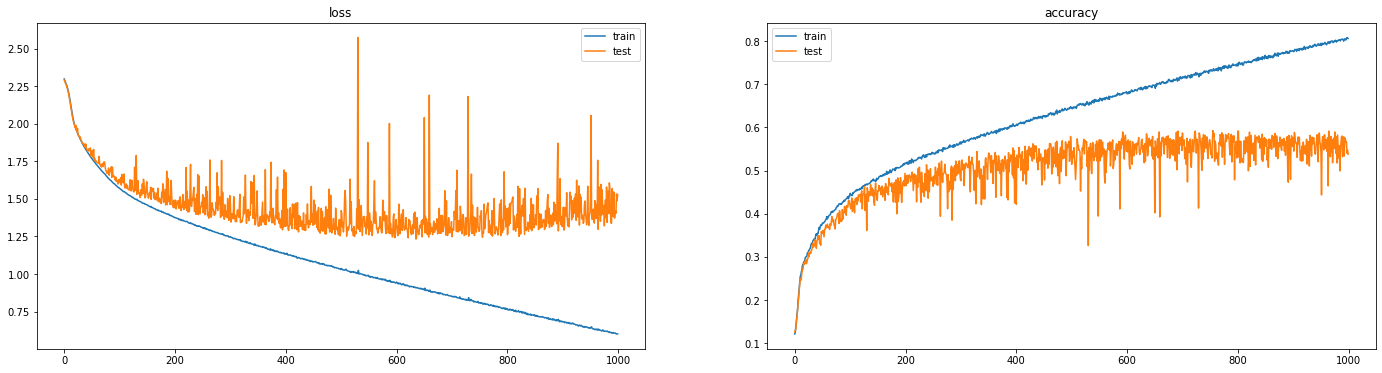

In [ ]:
val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy: {max(val_accuracies)}')

plot_loss_accuracy_curves(num_epochs, history.history)

In [ ]:
# 2. using RMSProp algorithm for learning
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

model = get_cnn(best_num_c1_channels, best_num_c2_channels)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # browser cannot handle too much output
)

highest validation accuracy: 0.5320000052452087


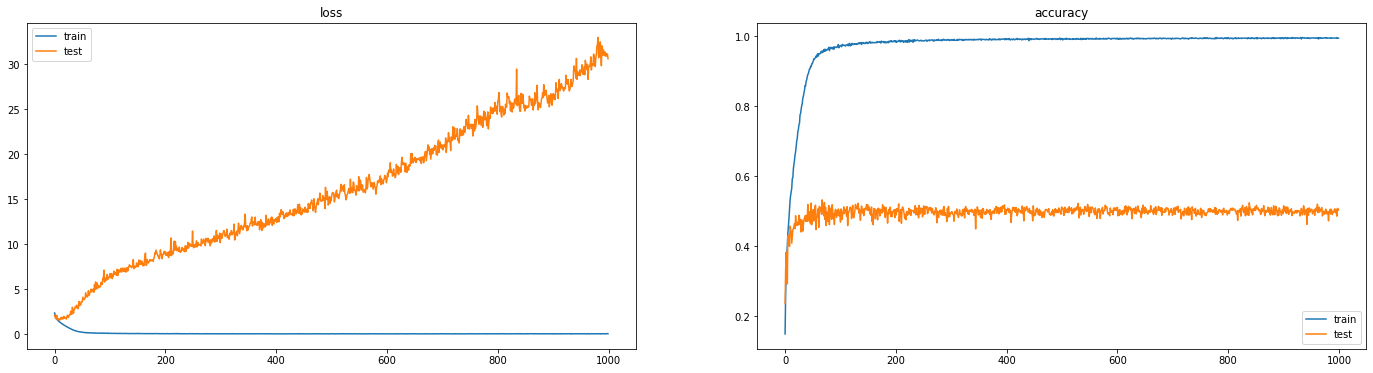

In [ ]:
val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy: {max(val_accuracies)}')

plot_loss_accuracy_curves(num_epochs, history.history)

In [ ]:
# 3. using Adam optimizer for learning
optimizer = tf.keras.optimizers.Adam(learning_rate)

model = get_cnn(best_num_c1_channels, best_num_c2_channels)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # browser cannot handle too much output
)

highest validation accuracy: 0.5404999852180481


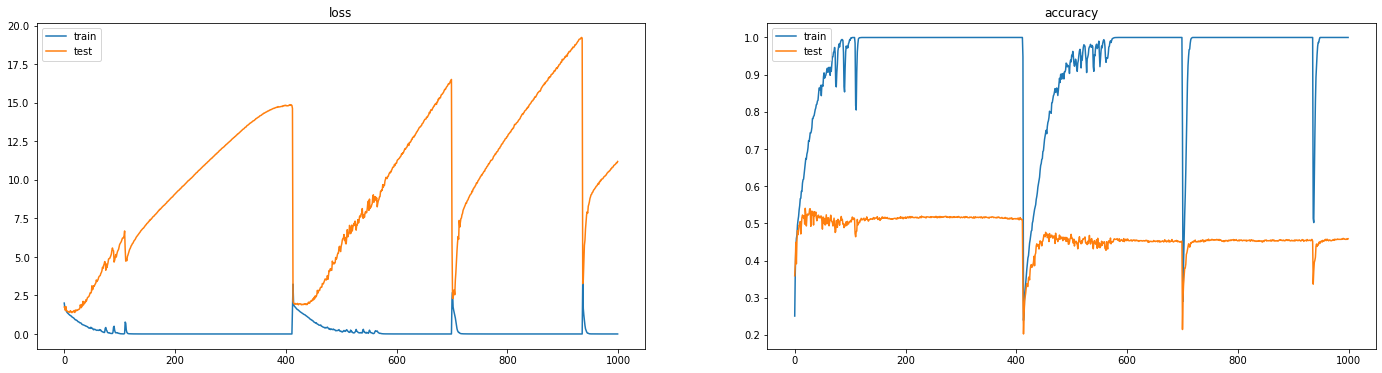

In [ ]:
val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy: {max(val_accuracies)}')

plot_loss_accuracy_curves(num_epochs, history.history)

In [ ]:
# 4. adding dropout (probability=0.5) to the two fully connected layers
optimizer = tf.keras.optimizers.SGD(learning_rate)

model = get_cnn(best_num_c1_channels, best_num_c2_channels, use_dropout=True)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # browser cannot handle too much output
)

highest validation accuracy: 0.6165000200271606


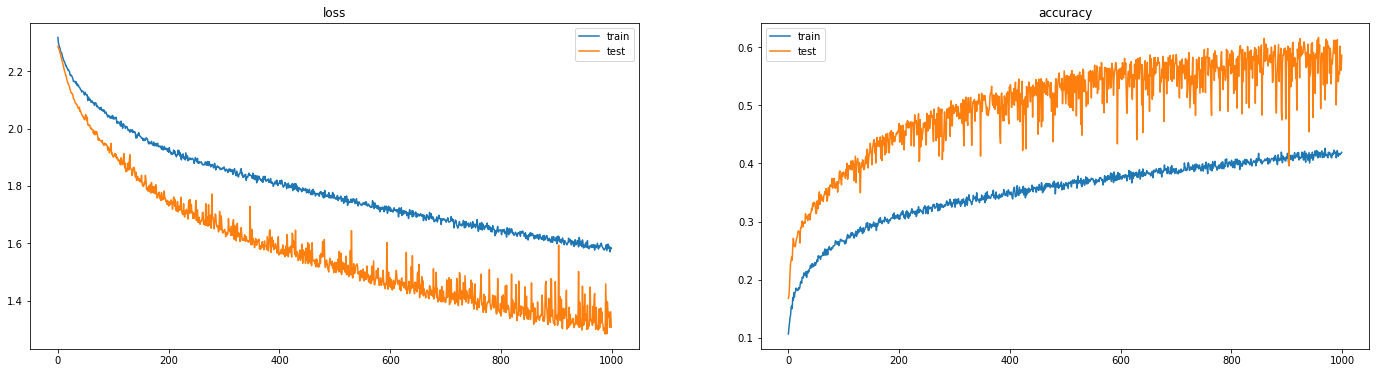

In [ ]:
val_accuracies = history.history['val_accuracy']
print(f'highest validation accuracy: {max(val_accuracies)}')

plot_loss_accuracy_curves(num_epochs, history.history)

# 4.

Compare the accuracies of all the models from parts (1) - (3) and discuss their performances.

In [ ]:
# check highest validation accuracy achieved by initial params
# 50 C1 channels, 60 C2 channels, SGD
val_accuracies = histories[(50, 60)]['val_accuracy']
print(f'highest val accuracy (original): {max(val_accuracies)}')

highest val accuracy (original): 0.5835000276565552


highest validation accuracies achieved:

- 50 C1 channels, 60 C1 channels, SGD, no dropout: 0.583500
- 90 C1 channels, 40 C1 channels, SGD, no dropout: 0.611500
- 90 C1 channels, 40 C1 channels, SGD-momentum, no dropout: 0.592499
- 90 C1 channels, 40 C1 channels, RMSProp, no dropout: 0.532000
- 90 C1 channels, 40 C1 channels, Adam, no dropout: 0.540499
- 90 C1 channels, 40 C1 channels, SGD, dropout: 0.616500